In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import h5py
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle
import time

## EDA & Pre-Processing 
- explore files in physionet folder
- look at metadata and merge different csvs 
- standardise naming and binarise (or discretise) attributes etc to fit with medfair framework
- split image paths into train val and test and save csvs

In [2]:
ROOT_FOLDER = '/gpfs3/well/papiez/shared/mimic-cxr-jpg/physionet.org/files/mimic-cxr-jpg/2.0.0'

In [3]:
robots_file_path= os.path.join(ROOT_FOLDER,'SHA256SUMS.txt')
with open(robots_file_path, 'r') as file:
    content = file.read()
    print(content)

426be4ad96cee93021a9cc5f17010f6d63f510c00461ea6dc4d01edd1ef7ade8 LICENSE.txt
af51555bca6c6caa60ac75759ad9f022cf86a7ce8e24c9bdb3fe497e159795fb README
8a827c9adfd17dc4c94b129b6a007e55d4f75af6e7686441eb386c5ff6d1ddde mimic-cxr-2.0.0-chexpert.csv.gz
6a3748ce77724c0dfe7d2def8f47643e989e3bbf0795bc13b89c1578e1649d6b mimic-cxr-2.0.0-metadata.csv.gz
22000d42f7b75aad764e87c129b4395804b25e340cc0d643d9f29b60dc404623 mimic-cxr-2.0.0-negbio.csv.gz
515997bd6649045d7443d60c59a4ce9f6cca6c478871b8f2fb13454462bedb2f mimic-cxr-2.0.0-split.csv.gz



In [4]:
readme_file_path= os.path.join(ROOT_FOLDER,'README')
with open(readme_file_path, 'r') as file:
    content = file.read()
    print(content)

# MIMIC-CXR-JPG v2.0.0

The MIMIC Chest X-ray JPG (MIMIC-CXR-JPG) Database v2.0.0 is a large publicly available dataset of chest radiographs in JPG format with structured labels derived from free-text radiology reports. The MIMIC-CXR-JPG dataset is wholly derived from MIMIC-CXR, providing JPG format files derived from the DICOM images and structured labels derived from the free-text reports. The aim of MIMIC-CXR-JPG is to provide a convenient processed version of MIMIC-CXR, as well as to provide a standard reference for data splits and image labels. The dataset contains 377,110 JPG format images and structured labels derived from the 227,827 free-text radiology reports associated with these images. The dataset is de-identified to satisfy the US Health Insurance Portability and Accountability Act of 1996 (HIPAA) Safe Harbor requirements. Protected health information (PHI) has been removed. The dataset is intended to support a wide body of research in medicine including image understandi

In [5]:
metadata_path = os.path.join(ROOT_FOLDER, 'mimic-cxr-2.0.0-metadata.csv.gz')
metadata_df = pd.read_csv(metadata_path)
metadata_df

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,CHEST (PA AND LAT),LATERAL,3056,2544,21800506,213014.531,CHEST (PA AND LAT),lateral,Erect
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),PA,3056,2544,21800626,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,CHEST (PA AND LAT),LATERAL,3056,2544,21800626,165500.312,CHEST (PA AND LAT),lateral,Erect
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,2705,2539,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
377105,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,19999733,57132437,CHEST (PA AND LAT),PA,3056,2544,21520708,224550.171,CHEST (PA AND LAT),postero-anterior,Erect
377106,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,19999733,57132437,CHEST (PA AND LAT),LATERAL,3056,2544,21520708,224550.171,CHEST (PA AND LAT),lateral,Erect
377107,58766883-376a15ce-3b323a28-6af950a0-16b793bd,19999987,55368167,CHEST (PORTABLE AP),AP,2544,3056,21451104,51448.218,CHEST (PORTABLE AP),antero-posterior,Erect
377108,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,19999987,58621812,CHEST (PORTABLE AP),AP,3056,2544,21451102,202809.234,CHEST (PORTABLE AP),antero-posterior,Erect


In [6]:
metadata_df['ViewPosition'].unique()

array(['PA', 'LATERAL', 'AP', 'LL', nan, 'LAO', 'RAO', 'AP AXIAL',
       'SWIMMERS', 'PA LLD', 'AP LLD', 'XTABLE LATERAL', 'AP RLD',
       'PA RLD', 'LPO'], dtype=object)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

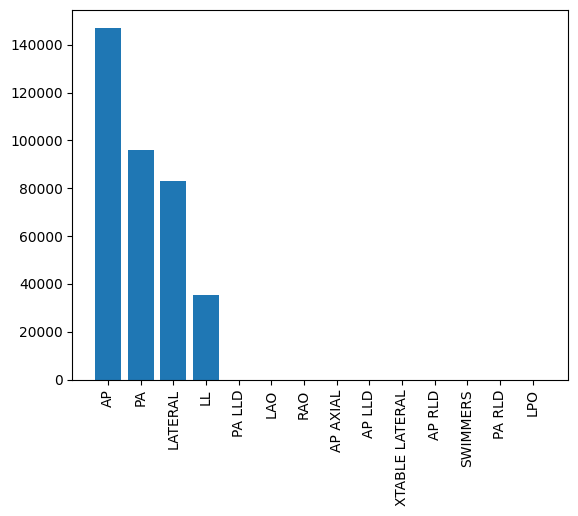

In [7]:
import matplotlib.pyplot as plt

counts =metadata_df['ViewPosition'].value_counts()
counts_df = counts.reset_index()
counts_df.columns = ['Value', 'Count']

counts_df['Count'].max()

plt.bar(counts_df['Value'],counts_df['Count'])
plt.xticks(rotation=90)

In [8]:
splits_path = os.path.join(ROOT_FOLDER, 'mimic-cxr-2.0.0-split.csv.gz')
splits_df = pd.read_csv(splits_path)
splits_df

,dicom_id,study_id,subject_id,split
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,50414267,10000032,train
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,50414267,10000032,train
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,53189527,10000032,train
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,53189527,10000032,train
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,53911762,10000032,train
...,...,...,...,...
377105,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,57132437,19999733,train
377106,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,57132437,19999733,train
377107,58766883-376a15ce-3b323a28-6af950a0-16b793bd,55368167,19999987,train
377108,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,58621812,19999987,train


In [9]:
negbio_path = os.path.join(ROOT_FOLDER, 'mimic-cxr-2.0.0-negbio.csv.gz')
negbio_df = pd.read_csv(negbio_path)
negbio_df

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227822,19999442,58708861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
227823,19999733,57132437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
227824,19999987,55368167,1.0,-1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN
227825,19999987,58621812,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [10]:
chexpert_path = os.path.join(ROOT_FOLDER, 'mimic-cxr-2.0.0-chexpert.csv.gz')
chexpert_df = pd.read_csv(chexpert_path)
chexpert_df
# each study id subject id combination is unique

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227822,19999442,58708861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
227823,19999733,57132437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
227824,19999987,55368167,1.0,-1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN
227825,19999987,58621812,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## Get paths of all images

In [11]:
len(os.listdir('/gpfs3/well/papiez/shared/mimic-cxr-jpg/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/'))

6397

In [12]:
os.listdir('/gpfs3/well/papiez/shared/mimic-cxr-jpg/physionet.org/files/mimic-cxr-jpg/2.0.0/files/')

['p16',
 'index.html',
 'p17',
 'p11',
 'p18',
 'p12',
 'p13',
 'p14',
 'p10',
 'p19',
 'p15']

In [13]:
# want a df with patient id, subject id, path to image

# root_file_path = '/gpfs3/well/papiez/shared/mimic-cxr-jpg/physionet.org/files/mimic-cxr-jpg/2.0.0/files/'
# patient_categories = [x for x in os.listdir(root_file_path) if 'index' not in x] #['p16', 'p17', 'p11', 'p18', 'p12', 'p13', 'p14', 'p10', 'p19', 'p15']

# all_patient_paths=[]
# for patient_cat in patient_categories:
#     patient_path = os.path.join(root_file_path,patient_cat)
#     all_patient_paths.append(find_images(patient_path))

# all_patient_paths

# flattened_list = [item for sublist in all_patient_paths for item in sublist]

# image_paths_df = pd.DataFrame()
# image_paths_df['path']=flattened_list

# image_paths_df['patient_cat'] = image_paths_df['path'].apply(lambda x: x.split("/")[-4])
# image_paths_df['patient_id'] = image_paths_df['path'].apply(lambda x: x.split("/")[-3])
# image_paths_df['subject_id'] = image_paths_df['path'].apply(lambda x: x.split("/")[-2])
# image_paths_df['image'] = image_paths_df['path'].apply(lambda x: x.split("/")[-1])

# # can there be multiple images per subject id?

# image_paths_df.to_csv('image_paths_df.csv', index=False)


In [40]:
image_paths_df = pd.read_csv('/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/data/other_data/mimic-cxr/image_paths_df.csv',names = ['path','patient_cat','subject_id','study_id','image'],header=0)
image_paths_df

,path,patient_cat,subject_id,study_id,image
0,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,p16319601,s52726134,c20654e3-3f4f8322-d732af7e-f214d42f-c16264fc.jpg
1,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,p16319601,s53409681,f5ffe72f-2177cc32-4bf7c5fa-c241b35c-447b2120.jpg
2,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,p16319601,s55001052,6eb86b7f-2137ab54-35697eb7-2a6108f9-07953b27.jpg
3,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,p16319601,s55001052,7432a1f0-43b19575-2821e077-0966143a-abc35d65.jpg
4,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,p16319601,s55001052,7d1a5c64-703847ae-fbf3b643-c3e08a4b-4153d0d7.jpg
...,...,...,...,...,...
355231,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,p15185911,s54694338,aa33a93b-c24b3814-a14bf1ca-c31571ee-b9bb4772.jpg
355232,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,p15185911,s58240684,a8bc92fc-0eb15c85-4c3f6cc9-f212b263-7d0b2928.jpg
355233,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,p15185911,s58240684,bdbde1d2-2ff72ddb-27ef5d1a-dfede03c-b697aac5.jpg
355234,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,p15185911,s55249927,ac3b0ffc-6e9d8e31-3af19eb9-c33293b1-0d7a038e.jpg


(array([9.6689e+04, 9.7400e+04, 1.8350e+04, 1.9920e+03, 9.3000e+01,
        3.3000e+01, 2.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00]),
 array([ 1.        ,  1.90909091,  2.81818182,  3.72727273,  4.63636364,
         5.54545455,  6.45454545,  7.36363636,  8.27272727,  9.18181818,
        10.09090909, 11.        ]),
 <BarContainer object of 11 artists>)

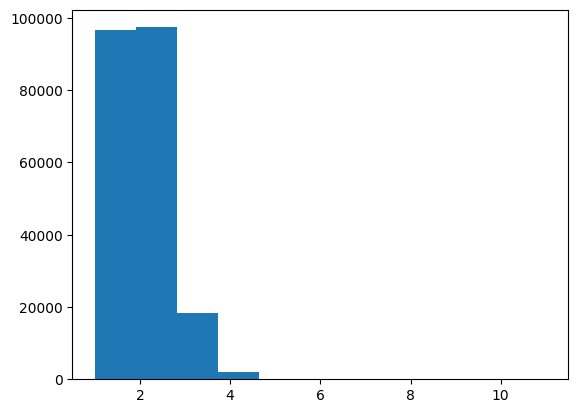

In [41]:
# need to find out if there is often multiple images of the sam`e patient and same subject

import matplotlib.pyplot as plt

image_paths_df['patient_study_id']= image_paths_df['subject_id']+image_paths_df['study_id']
counts =image_paths_df['patient_study_id'].value_counts()
counts_df = counts.reset_index()
counts_df.columns = ['Value', 'Count']

counts_df['Count'].max()

plt.hist(counts_df['Count'],bins=11)

# mostly 1 or two images per patient per subject id, max is 11

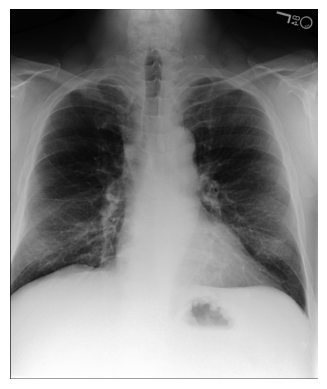

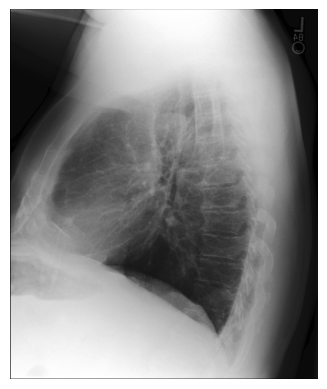

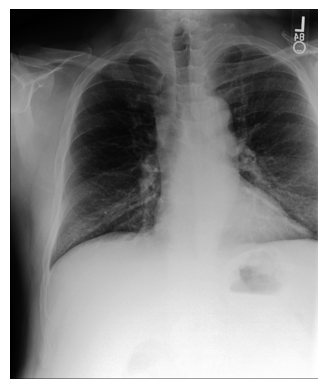

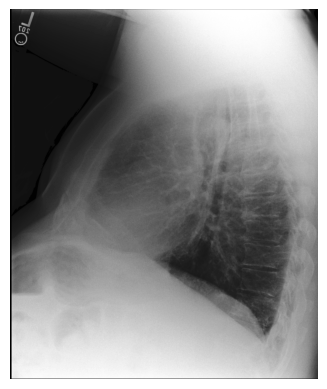

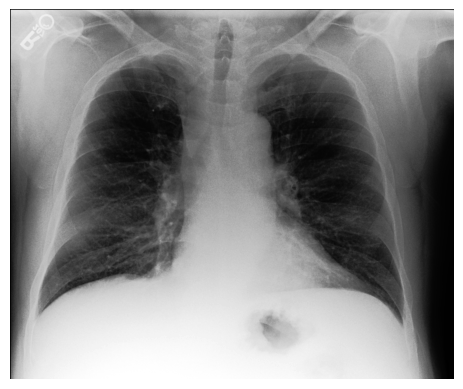

In [15]:
import matplotlib.pyplot as plt
from PIL import Image

def find_images(folder_path):
    image_paths = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith('.jpg'):
                image_paths.append(os.path.join(root, file))

    return image_paths
    
example_patient_path = '/gpfs3/well/papiez/shared/mimic-cxr-jpg/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10999737/' #patient id folder contains different subject ids
patient_image_paths = find_images(example_patient_path)

for image in patient_image_paths:
    img = Image.open(image).convert('L')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()


## Metadata

In [17]:
metadata_path = '/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/physionet.org/files/mimiciv/2.2/hosp/'
patients_file = 'patients.csv.gz'
admissions_file = 'admissions.csv.gz'

patients_df = pd.read_csv(os.path.join(metadata_path,patients_file))
patients_df

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN
...,...,...,...,...,...,...
299707,19999828,F,46,2147,2017 - 2019,NaN
299708,19999829,F,28,2186,2008 - 2010,NaN
299709,19999840,M,58,2164,2008 - 2010,2164-09-17
299710,19999914,F,49,2158,2017 - 2019,NaN


In [18]:
admissions_df = pd.read_csv(os.path.join(metadata_path,admissions_file))
admissions_df_no_duplicates = admissions_df.drop_duplicates(subset='subject_id')
admissions_df_no_duplicates = admissions_df_no_duplicates[['subject_id','hadm_id','insurance','language','marital_status','race']] # keep only relevant columns
admissions_df_no_duplicates
# this reduces number of rows from 431231 to 180733

,subject_id,hadm_id,insurance,language,marital_status,race
0,10000032,22595853,Other,ENGLISH,WIDOWED,WHITE
4,10000068,25022803,Other,ENGLISH,SINGLE,WHITE
5,10000084,23052089,Medicare,ENGLISH,MARRIED,WHITE
7,10000108,27250926,Other,ENGLISH,SINGLE,WHITE
8,10000117,22927623,Other,ENGLISH,DIVORCED,WHITE
...,...,...,...,...,...,...
431207,19999733,27674281,Other,ENGLISH,SINGLE,WHITE
431208,19999784,21739106,Other,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN
431226,19999828,25744818,Other,ENGLISH,SINGLE,WHITE
431228,19999840,21033226,Other,ENGLISH,WIDOWED,WHITE


In [19]:
patients_admissions_df = pd.merge(admissions_df_no_duplicates, patients_df, on='subject_id',how='outer')
# patient_df has no repeating subject ids so merge on this df 
patients_admissions_df

,subject_id,hadm_id,insurance,language,marital_status,race,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,22595853.0,Other,ENGLISH,WIDOWED,WHITE,F,52,2180,2014 - 2016,2180-09-09
1,10000068,25022803.0,Other,ENGLISH,SINGLE,WHITE,F,19,2160,2008 - 2010,NaN
2,10000084,23052089.0,Medicare,ENGLISH,MARRIED,WHITE,M,72,2160,2017 - 2019,2161-02-13
3,10000108,27250926.0,Other,ENGLISH,SINGLE,WHITE,M,25,2163,2014 - 2016,NaN
4,10000117,22927623.0,Other,ENGLISH,DIVORCED,WHITE,F,48,2174,2008 - 2010,NaN
...,...,...,...,...,...,...,...,...,...,...,...
299707,19999659,NaN,NaN,NaN,NaN,NaN,F,58,2181,2011 - 2013,NaN
299708,19999750,NaN,NaN,NaN,NaN,NaN,M,45,2144,2017 - 2019,NaN
299709,19999782,NaN,NaN,NaN,NaN,NaN,F,22,2156,2008 - 2010,NaN
299710,19999829,NaN,NaN,NaN,NaN,NaN,F,28,2186,2008 - 2010,NaN


In [20]:
# keep only essential columns
metadata_df = patients_admissions_df[['subject_id','race','gender','anchor_age']]
metadata_df

,subject_id,race,gender,anchor_age
0,10000032,WHITE,F,52
1,10000068,WHITE,F,19
2,10000084,WHITE,M,72
3,10000108,WHITE,M,25
4,10000117,WHITE,F,48
...,...,...,...,...
299707,19999659,NaN,F,58
299708,19999750,NaN,M,45
299709,19999782,NaN,F,22
299710,19999829,NaN,F,28


In [21]:
# patients without a race attribute
filtered_df = metadata_df[pd.isna(metadata_df['race'])]
len(filtered_df)

118979

## Pre-process metadata

In [22]:
# metadata
metadata_df

,subject_id,race,gender,anchor_age
0,10000032,WHITE,F,52
1,10000068,WHITE,F,19
2,10000084,WHITE,M,72
3,10000108,WHITE,M,25
4,10000117,WHITE,F,48
...,...,...,...,...
299707,19999659,NaN,F,58
299708,19999750,NaN,M,45
299709,19999782,NaN,F,22
299710,19999829,NaN,F,28


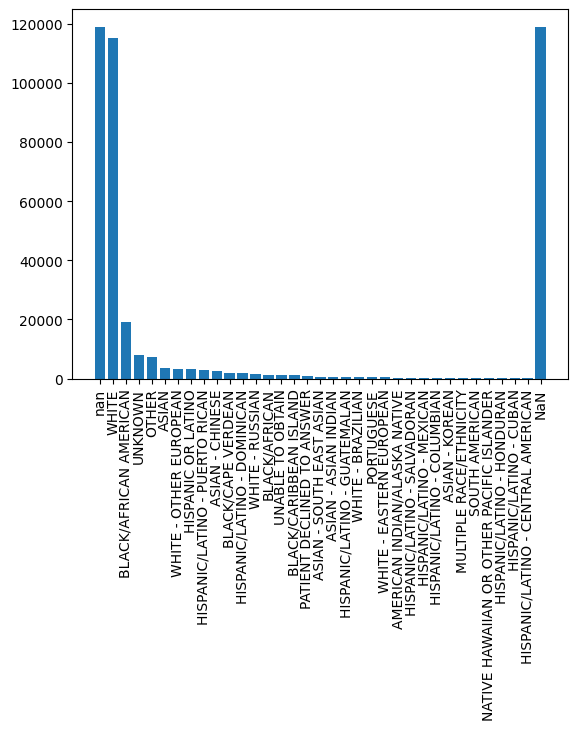

In [23]:
counts = metadata_df['race'].value_counts(dropna=False)

# Handling NaN separately
nan_count = metadata_df['race'].isna().sum()
counts['NaN'] = nan_count

counts_df = counts.reset_index()
counts_df.columns = ['Value', 'Count']

# Convert 'Value' column to strings
counts_df['Value'] = counts_df['Value'].astype(str)

# Plotting
plt.bar(counts_df['Value'], counts_df['Count'])
plt.xticks(rotation=90)
plt.show()


(array([158553.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 141159.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

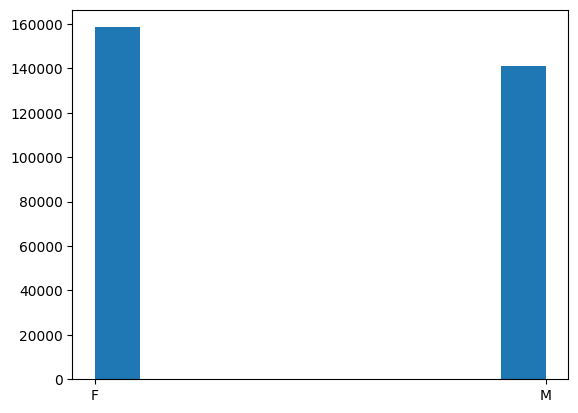

In [24]:
plt.hist(metadata_df['gender'])

(array([55465., 35848., 27666., 29531., 30725., 31281., 31915., 21669.,
        17693., 17919.]),
 array([18. , 25.3, 32.6, 39.9, 47.2, 54.5, 61.8, 69.1, 76.4, 83.7, 91. ]),
 <BarContainer object of 10 artists>)

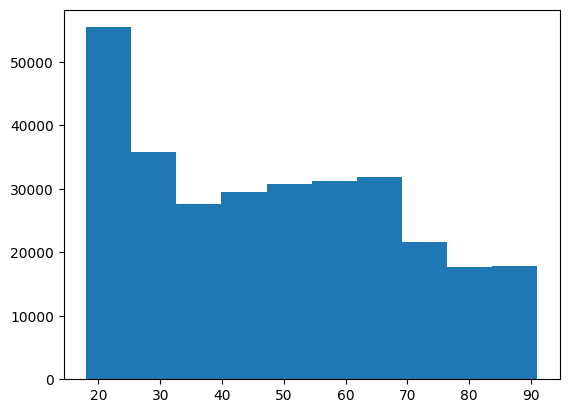

In [25]:
plt.hist(metadata_df['anchor_age'])

In [42]:
# binarise ethnicity

metadata_df = metadata_df.dropna() # this removes 118979 rows - need to remove other patients
metadata_df = metadata_df[~metadata_df['race'].isin(['UNKNOWN', 'UNABLE TO OBTAIN'])] # this removes 9133 rows
metadata_df['race_binary'] = metadata_df['race'].apply(lambda x: 'WHITE' if 'WHITE' in x else 'NON-WHITE') # not sure if other whites should count in white (eg white-russian, white-brazilian etc)


In [27]:
# binarise age
metadata_df['Age_multi'] = metadata_df['anchor_age'].values.astype('int')
metadata_df['Age_multi'] = np.where(metadata_df['Age_multi'].between(-1,19), 0, metadata_df['Age_multi'])
metadata_df['Age_multi'] = np.where(metadata_df['Age_multi'].between(20,39), 1, metadata_df['Age_multi'])
metadata_df['Age_multi'] = np.where(metadata_df['Age_multi'].between(40,59), 2, metadata_df['Age_multi'])
metadata_df['Age_multi'] = np.where(metadata_df['Age_multi'].between(60,79), 3, metadata_df['Age_multi'])
metadata_df['Age_multi'] = np.where(metadata_df['Age_multi']>=80, 4, metadata_df['Age_multi'])

metadata_df['Age_binary'] = metadata_df['anchor_age'].values.astype('int')
metadata_df['Age_binary'] = np.where(metadata_df['Age_binary'].between(-1, 60), 0, metadata_df['Age_binary'])
metadata_df['Age_binary'] = np.where(metadata_df['Age_binary']>= 60, 1, metadata_df['Age_binary'])
metadata_df

,subject_id,race,gender,anchor_age,race_binary,Age_multi,Age_binary
0,10000032,WHITE,F,52,WHITE,2,0
1,10000068,WHITE,F,19,WHITE,0,0
2,10000084,WHITE,M,72,WHITE,3,1
3,10000108,WHITE,M,25,WHITE,1,0
4,10000117,WHITE,F,48,WHITE,2,0
...,...,...,...,...,...,...,...
180727,19999625,WHITE,M,81,WHITE,4,1
180728,19999733,WHITE,F,19,WHITE,0,0
180729,19999784,BLACK/AFRICAN AMERICAN,M,57,NON-WHITE,2,0
180730,19999828,WHITE,F,46,WHITE,2,0


(array([ 3084.,     0., 41774.,     0.,     0., 49843.,     0., 53559.,
            0., 23340.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

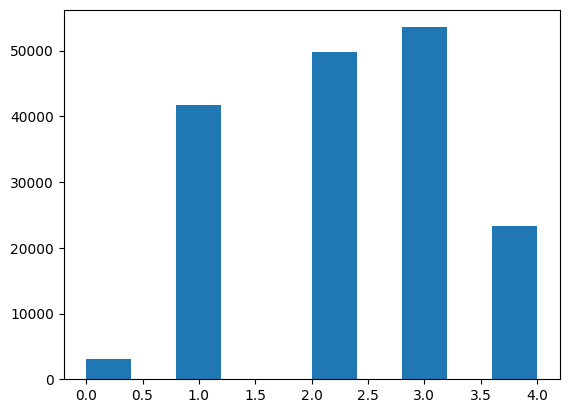

In [28]:
plt.hist(metadata_df['Age_multi'])

(array([120853.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  50747.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

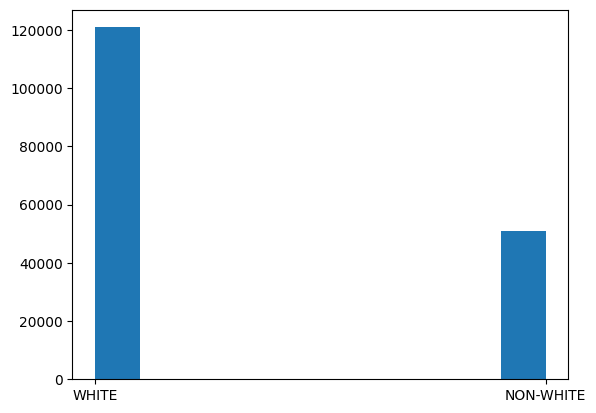

In [29]:
plt.hist(metadata_df['race_binary'])

In [30]:
metadata_df

,subject_id,race,gender,anchor_age,race_binary,Age_multi,Age_binary
0,10000032,WHITE,F,52,WHITE,2,0
1,10000068,WHITE,F,19,WHITE,0,0
2,10000084,WHITE,M,72,WHITE,3,1
3,10000108,WHITE,M,25,WHITE,1,0
4,10000117,WHITE,F,48,WHITE,2,0
...,...,...,...,...,...,...,...
180727,19999625,WHITE,M,81,WHITE,4,1
180728,19999733,WHITE,F,19,WHITE,0,0
180729,19999784,BLACK/AFRICAN AMERICAN,M,57,NON-WHITE,2,0
180730,19999828,WHITE,F,46,WHITE,2,0


In [31]:
# labels
# remove any subjects that have been dropped in metadata - this removes 33269 rows
chexpert_df = chexpert_df[chexpert_df['subject_id'].isin(metadata_df['subject_id'])]
chexpert_df

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227818,19999287,53282218,NaN,0.0,NaN,NaN,NaN,NaN,-1.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN
227819,19999287,58938059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
227821,19999442,58497551,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,-1.0,NaN,NaN,0.0,NaN
227822,19999442,58708861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [37]:
len(chexpert_df[chexpert_df['No Finding']==1.0])/len(chexpert_df)

0.31127030001337047

In [43]:
# image paths
# also drop any dropped subjects - removes 54189 rows
image_paths_df['subject_id'] = image_paths_df['subject_id'].str.replace('p', '') # standardise naming
image_paths_df['subject_id'] = image_paths_df['subject_id'].astype(int)
image_paths_df['study_id'] = image_paths_df['study_id'].str.replace('s', '') # standardise naming
image_paths_df['study_id'] = image_paths_df['study_id'].astype(int)
image_paths_df = image_paths_df[image_paths_df['subject_id'].isin(metadata_df['subject_id'])]
image_paths_df

,path,patient_cat,subject_id,study_id,image,patient_study_id
0,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16319601,52726134,c20654e3-3f4f8322-d732af7e-f214d42f-c16264fc.jpg,p16319601s52726134
1,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16319601,53409681,f5ffe72f-2177cc32-4bf7c5fa-c241b35c-447b2120.jpg,p16319601s53409681
2,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16319601,55001052,6eb86b7f-2137ab54-35697eb7-2a6108f9-07953b27.jpg,p16319601s55001052
3,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16319601,55001052,7432a1f0-43b19575-2821e077-0966143a-abc35d65.jpg,p16319601s55001052
4,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16319601,55001052,7d1a5c64-703847ae-fbf3b643-c3e08a4b-4153d0d7.jpg,p16319601s55001052
...,...,...,...,...,...,...
355231,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15185911,54694338,aa33a93b-c24b3814-a14bf1ca-c31571ee-b9bb4772.jpg,p15185911s54694338
355232,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15185911,58240684,a8bc92fc-0eb15c85-4c3f6cc9-f212b263-7d0b2928.jpg,p15185911s58240684
355233,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15185911,58240684,bdbde1d2-2ff72ddb-27ef5d1a-dfede03c-b697aac5.jpg,p15185911s58240684
355234,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15185911,55249927,ac3b0ffc-6e9d8e31-3af19eb9-c33293b1-0d7a038e.jpg,p15185911s55249927


In [49]:
# create one big df

all_meta_df = pd.merge(image_paths_df,metadata_df,on='subject_id',how='left')
all_meta_df
## still need to sort out labels and add to big dataframe!!

,path,patient_cat,subject_id,study_id,image,patient_study_id,race,gender,anchor_age,race_binary,Age_multi,Age_binary
0,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16319601,52726134,c20654e3-3f4f8322-d732af7e-f214d42f-c16264fc.jpg,p16319601s52726134,WHITE,M,66,WHITE,3,1
1,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16319601,53409681,f5ffe72f-2177cc32-4bf7c5fa-c241b35c-447b2120.jpg,p16319601s53409681,WHITE,M,66,WHITE,3,1
2,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16319601,55001052,6eb86b7f-2137ab54-35697eb7-2a6108f9-07953b27.jpg,p16319601s55001052,WHITE,M,66,WHITE,3,1
3,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16319601,55001052,7432a1f0-43b19575-2821e077-0966143a-abc35d65.jpg,p16319601s55001052,WHITE,M,66,WHITE,3,1
4,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16319601,55001052,7d1a5c64-703847ae-fbf3b643-c3e08a4b-4153d0d7.jpg,p16319601s55001052,WHITE,M,66,WHITE,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
301042,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15185911,54694338,aa33a93b-c24b3814-a14bf1ca-c31571ee-b9bb4772.jpg,p15185911s54694338,BLACK/AFRICAN AMERICAN,F,63,NON-WHITE,3,1
301043,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15185911,58240684,a8bc92fc-0eb15c85-4c3f6cc9-f212b263-7d0b2928.jpg,p15185911s58240684,BLACK/AFRICAN AMERICAN,F,63,NON-WHITE,3,1
301044,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15185911,58240684,bdbde1d2-2ff72ddb-27ef5d1a-dfede03c-b697aac5.jpg,p15185911s58240684,BLACK/AFRICAN AMERICAN,F,63,NON-WHITE,3,1
301045,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15185911,55249927,ac3b0ffc-6e9d8e31-3af19eb9-c33293b1-0d7a038e.jpg,p15185911s55249927,BLACK/AFRICAN AMERICAN,F,63,NON-WHITE,3,1


In [51]:
all_meta_df = pd.merge(all_meta_df,chexpert_df,on=['subject_id','study_id'],how='left')
all_meta_df

,path,patient_cat,subject_id,study_id,image,patient_study_id,race,gender,anchor_age,race_binary,...,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16319601,52726134,c20654e3-3f4f8322-d732af7e-f214d42f-c16264fc.jpg,p16319601s52726134,WHITE,M,66,WHITE,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0
1,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16319601,53409681,f5ffe72f-2177cc32-4bf7c5fa-c241b35c-447b2120.jpg,p16319601s53409681,WHITE,M,66,WHITE,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,1.0
2,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16319601,55001052,6eb86b7f-2137ab54-35697eb7-2a6108f9-07953b27.jpg,p16319601s55001052,WHITE,M,66,WHITE,...,0.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0
3,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16319601,55001052,7432a1f0-43b19575-2821e077-0966143a-abc35d65.jpg,p16319601s55001052,WHITE,M,66,WHITE,...,0.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0
4,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p16,16319601,55001052,7d1a5c64-703847ae-fbf3b643-c3e08a4b-4153d0d7.jpg,p16319601s55001052,WHITE,M,66,WHITE,...,0.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301042,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15185911,54694338,aa33a93b-c24b3814-a14bf1ca-c31571ee-b9bb4772.jpg,p15185911s54694338,BLACK/AFRICAN AMERICAN,F,63,NON-WHITE,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
301043,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15185911,58240684,a8bc92fc-0eb15c85-4c3f6cc9-f212b263-7d0b2928.jpg,p15185911s58240684,BLACK/AFRICAN AMERICAN,F,63,NON-WHITE,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
301044,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15185911,58240684,bdbde1d2-2ff72ddb-27ef5d1a-dfede03c-b697aac5.jpg,p15185911s58240684,BLACK/AFRICAN AMERICAN,F,63,NON-WHITE,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
301045,/gpfs3/well/papiez/shared/mimic-cxr-jpg/physio...,p15,15185911,55249927,ac3b0ffc-6e9d8e31-3af19eb9-c33293b1-0d7a038e.jpg,p15185911s55249927,BLACK/AFRICAN AMERICAN,F,63,NON-WHITE,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


## Split train/val/test

In [55]:
def split_811(all_meta, patient_ids):
    sub_train, sub_val_test = train_test_split(patient_ids, test_size=0.2, random_state=0) # splits based on patient_id (not studies)
    sub_val, sub_test = train_test_split(sub_val_test, test_size=0.5, random_state=0)
    train_meta = all_meta[all_meta.subject_id.isin(sub_train)]
    val_meta = all_meta[all_meta.subject_id.isin(sub_val)]
    test_meta = all_meta[all_meta.subject_id.isin(sub_test)]
    return train_meta, val_meta, test_meta

sub_train, sub_val, sub_test = split_811(all_meta_df, np.unique(all_meta_df['subject_id']))

In [ ]:
root = '/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/'
sub_train.to_csv(os.path.join(root,'data/mimic-cxr/splits/train.csv'))
sub_val.to_csv(os.path.join(root,'data/mimic-cxr/splits/val.csv'))
sub_test.to_csv(os.path.join(root,'data/mimic-cxr/splits/test.csv'))

In [3]:
root = '/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/'
sub_train = pd.read_csv(os.path.join(root,'data/mimic-cxr/splits/train.csv'))

In [69]:
# # standardise naming!
# root = '/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/'
# sub_train_df = pd.read_csv(os.path.join(root,'data/mimic-cxr/splits/train.csv'))
# sub_val_df = pd.read_csv(os.path.join(root,'data/mimic-cxr/splits/val.csv'))
# sub_test_df= pd.read_csv(os.path.join(root,'data/mimic-cxr/splits/test.csv'))

# sub_train_df['race_binary'] = sub_train_df['race_binary'].replace({'WHITE': 'White', 'NON-WHITE': 'non-White'})
# sub_val_df['race_binary'] = sub_val_df['race_binary'].replace({'WHITE': 'White', 'NON-WHITE': 'non-White'})
# sub_test_df['race_binary'] = sub_test_df['race_binary'].replace({'WHITE': 'White', 'NON-WHITE': 'non-White'})

# sub_train_df = sub_train_df.rename(columns={'gender': 'Sex', 'race_binary': 'Race', 'race': 'Race_multi'})
# sub_val_df = sub_val_df.rename(columns={'gender': 'Sex', 'race_binary': 'Race', 'race': 'Race_multi'})
# sub_test_df = sub_test_df.rename(columns={'gender': 'Sex', 'race_binary': 'Race', 'race': 'Race_multi'})

# sub_train_df = sub_train_df.drop('Unnamed: 0', axis=1, errors='ignore')
# sub_val_df = sub_val_df.drop('Unnamed: 0', axis=1, errors='ignore')
# sub_test_df = sub_test_df.drop('Unnamed: 0', axis=1, errors='ignore')

# sub_train_df.to_csv(os.path.join(root,'data/mimic-cxr/splits/train.csv'))
# sub_val_df.to_csv(os.path.join(root,'data/mimic-cxr/splits/val.csv'))
# sub_test_df.to_csv(os.path.join(root,'data/mimic-cxr/splits/test.csv'))

See separate python scripts to save images as pkl files